In [1]:
import math
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io.wavfile import read as wavread
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from textgrids import TextGrid

import IPython.display as ipd

In [2]:
def fix_length(array, desired_length: int):
    """ Helper function to make all arrays the same length in third dimension """
    if array.shape[2] > desired_length:
        return array[:, :, :desired_length]
    elif array.shape[2] < desired_length:
        return np.concatenate([
            array, 
            np.zeros((array.shape[0], array.shape[1], desired_length - array.shape[2]))
        ], axis=2)
    else:
        return array

def normalize(array, minval: float, maxval: float):
    """ Helper function to normalize array from range `[minval,maxval]` to `[0,1]`. """
    return (array - minval) / (maxval - minval)

The following cell contains the intersection of words between the HP chapter 1 and the VariaNTS corpus. 

If we want to select only certain classes to make training easier, we can do that here by commenting out line 7. Note that *dag* and *wel* are the most frequent words in the HP chapter.

In [3]:
# The words that overlap between HP chapter 1 and the VariaNTS corpus are hardcoded here for brevity
variaNTS_intersection = 'bed,boel,brief,bril,dag,dier,doel,dood,feest,goed,greep,half,hand,heel,heer,hoofd,hoop,kalm,kan,kant,keel,keer,kind,klein,kneep,kwaad,laat,land,lang,licht,los,man,meer,mond,mot,neus,paar,raam,rest,snel,stad,steen,stijf,stuur,tijd,vol,vorm,vroeg,weg,wel,werk,wind,zet,zin,zoon'

variaNTS_intersection = variaNTS_intersection.split(',')

# If we want to select only certain classes, we can do that here:
# variaNTS_intersection = ['dag', 'wel']

print(variaNTS_intersection)

['bed', 'boel', 'brief', 'bril', 'dag', 'dier', 'doel', 'dood', 'feest', 'goed', 'greep', 'half', 'hand', 'heel', 'heer', 'hoofd', 'hoop', 'kalm', 'kan', 'kant', 'keel', 'keer', 'kind', 'klein', 'kneep', 'kwaad', 'laat', 'land', 'lang', 'licht', 'los', 'man', 'meer', 'mond', 'mot', 'neus', 'paar', 'raam', 'rest', 'snel', 'stad', 'steen', 'stijf', 'stuur', 'tijd', 'vol', 'vorm', 'vroeg', 'weg', 'wel', 'werk', 'wind', 'zet', 'zin', 'zoon']


The following cell creates trainable data (ECoG segments matched with labels) from the original dataframes. 

For each subject, there are two recording runs, and per run, there are two frequency bands (high and low). For the words that we are interested in, we get the appropriate timestamps from a `TextGrid` file, that we use to cut out segments from the dataframes containing the ECoG recordings in the two frequency bands. 

For each cut-out segment, we therefore have two dataframe sections, that we combine into a single numpy array. Note that there are several ways of doing so; I have so far stacked them along the 2nd axis, such that the resulting array is of shape `(ELECTRODES, FREQ BANDS, TIMESTEPS)`.

For convolutional classifiers, these can stay as 3D arrays. However, MLPs or SVMs expect 1D arrays, which is why the arrays are flattened in the code below.

In [4]:
ECOG_SAMPLERATE = 100
# The length along the 3rd (time) axis to which to set all segments to
SEGMENT_LENGTH = 40
# The subject to process
SUB = 1

data = []
labels = []
lengths = []

for RUN in [1,2]:
    # Define subject and run specific paths
    data_dir = Path(f'/home/passch/thesis/data/hp_reading/sub-00{SUB}/')
    ecog_dir = data_dir / f'sub-00{SUB}_ses-iemu_acq-ECOG_run-0{RUN}_ieeg'
    
    # Load both frequency bands as pandas dataframes 
    ecog_df_lfb = pd.read_csv(
        ecog_dir / 'lfb_hp_reading_ecog_car_1-30_avgfirst_100Hz_log.csv')
    ecog_df_hfb = pd.read_csv(
        ecog_dir / 'hfb_hp_reading_ecog_car_70-170_avgfirst_100Hz_log.csv')

    # The TextGrid which contains all detected word intervals
    textgrid = TextGrid(
        data_dir / f'sub-00{SUB}_ses-iemu_acq-ECOG_run-0{RUN}_audio.TextGrid')

    # The audio file of the recording
    audio_samplerate, audio_signal = wavread(
        data_dir / f'sub-00{SUB}_ses-iemu_acq-ECOG_run-0{RUN}_audio_pitch_shifted.wav')

    # Pick the relevant intervals from the text grid, i.e. only those of words in the intersection
    variaNTS_intervals = [
        interval for interval in textgrid['words']
        if interval.text in variaNTS_intersection
    ]

    for interval in tqdm(variaNTS_intervals):
        # Chop sections out of ECOG dataframes
        ecog_lfb = ecog_df_lfb.iloc[
            math.floor(interval.xmin * ECOG_SAMPLERATE) :
            math.ceil(interval.xmax * ECOG_SAMPLERATE) + 1
            # math.floor(interval.xmin * ECOG_SAMPLERATE) + 20
        ]
        ecog_hfb = ecog_df_hfb.iloc[
            math.floor(interval.xmin * ECOG_SAMPLERATE) :
            math.ceil(interval.xmax * ECOG_SAMPLERATE) + 1
            # math.floor(interval.xmin * ECOG_SAMPLERATE) + 20
        ]

        # Both ECoG segments have shape (TIMESTEPS, ELECTRODES). We transpose 
        # both and stack them into a single array along the 2nd axis.
        ecog = np.stack([ecog_lfb.T, ecog_hfb.T], axis=1) # Gives shape (ELECTRODES, FREQ BANDS, TIMESTEPS)

        # Collect the original lengths of the samples for later plotting
        lengths.append(ecog.shape[2])

        # Fix the length in the 3rd (time) dimension to the same length for 
        # all recordings. This appends zeros for those shorter than SEGMENT_LENGTH
        ecog = fix_length(ecog, SEGMENT_LENGTH)

        ecog = ecog.flatten()

        ecog = normalize(ecog, minval=5, maxval=11)
        
        ecog.astype(np.float32)
        
        data.append(ecog)
        labels.append(interval.text)

n_classes = len(np.unique(labels))

100%|██████████| 125/125 [00:00<00:00, 2498.41it/s]


Here we randomly sample an interval and load the appropriate audio to check if the intervals are correctly aligned

In [5]:
interval =  variaNTS_intervals[np.random.choice(len(variaNTS_intervals))]
interval_sig = audio_signal[
    int(interval.xmin * audio_samplerate) : 
    int(interval.xmax * audio_samplerate) 
]
print(interval.text) 
ipd.Audio(interval_sig, rate=audio_samplerate)

brief


Compute train test split and fit a classifier

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

In [7]:
clf = SVC()
clf.fit(X_train, y_train)
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)

print(train_acc, test_acc)

0.19375 0.175


Most of the time, the classifier will simply collapse to the most frequent word, *wel*, or a selection of a 1-4 others, which can be seen with confusion matrices:

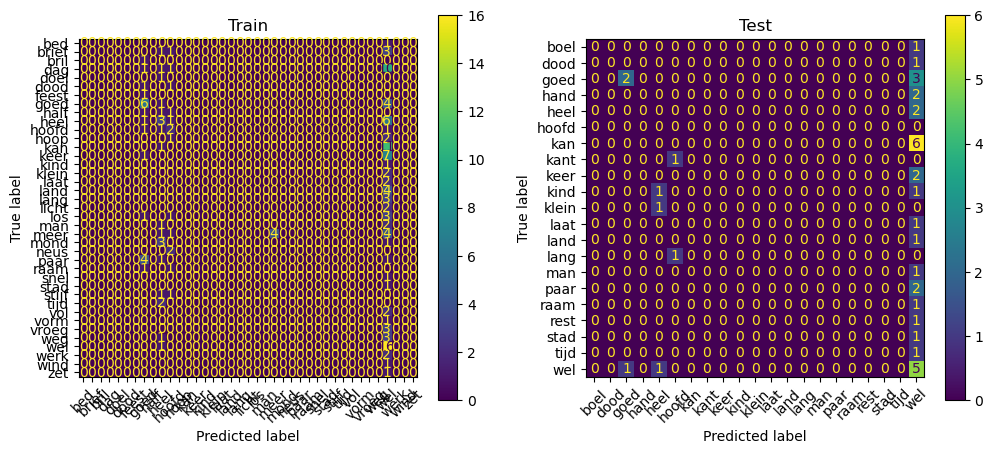

In [8]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax1.set_title('Train')
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax=ax1, xticks_rotation=45)
ax2 = plt.subplot(122)
ax2.set_title('Test')
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax2, xticks_rotation=45)
plt.show()

Some additional exploration: reducing dimensionality with TSNE to check along what features the data may cluster. We can see in the plots below that there is no visible correspondence for labels (left plot), while the original length (i.e. number of added zeros) gets picked up on (right plot). 

In [9]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(np.array(data))

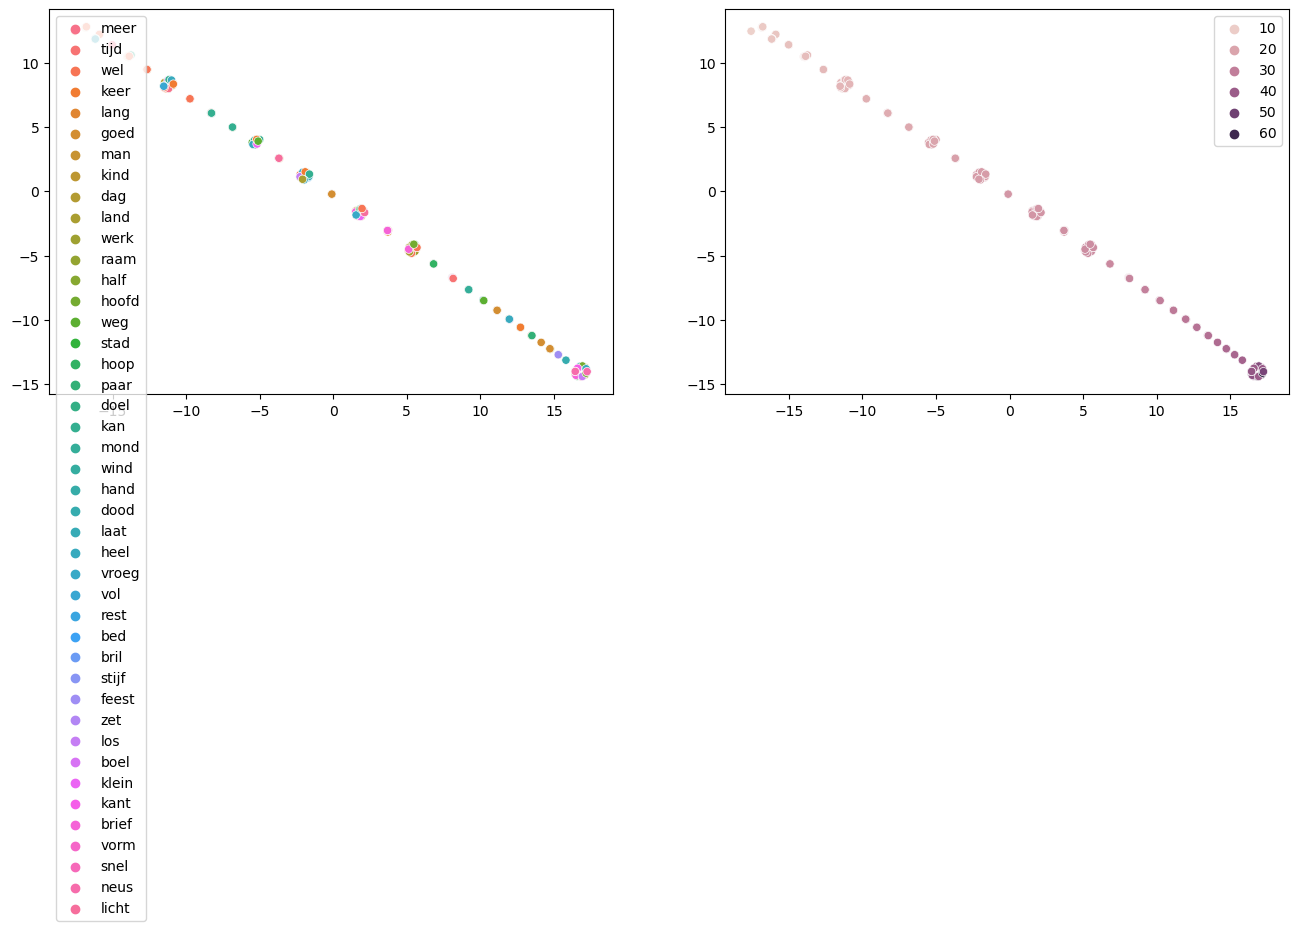

In [10]:
plt.figure(figsize=(16,5))
plt.subplot(121)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=labels)
plt.subplot(122)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=lengths)
plt.show()

## Some additional plots

This plots the distribution of lengths of the different ECoG samples. Useful for determining which `SEGMENT_LENGTH` to use.

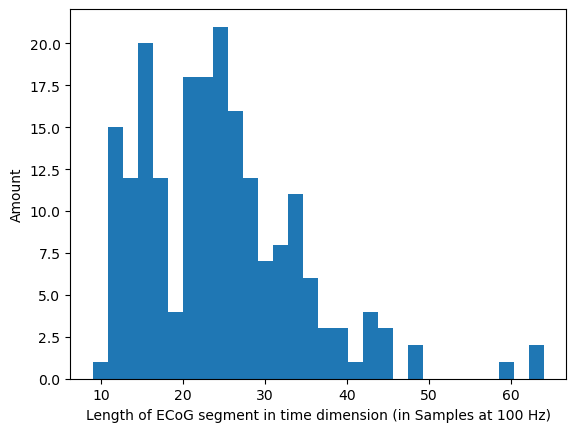

Mean and median lengths: 24.47 23.5


In [11]:
plt.hist(lengths, bins=30)
plt.xlabel('Length of ECoG segment in time dimension (in Samples at 100 Hz)')
plt.ylabel('Amount')
plt.show()
print('Mean and median lengths:', np.mean(lengths), np.median(lengths))

Here we can plot a random ECoG file. We can see the difference between high and low frequency bands.

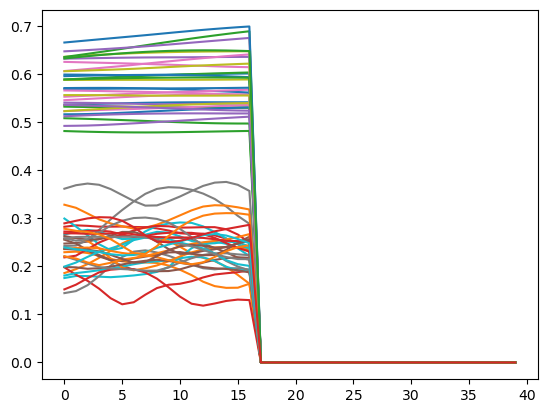

In [12]:
interval =  variaNTS_intervals[np.random.choice(len(variaNTS_intervals))]

ecog_lfb = ecog_df_lfb.iloc[
    math.floor(interval.xmin * ECOG_SAMPLERATE) :
    math.ceil(interval.xmax * ECOG_SAMPLERATE) + 1
    # math.floor(interval.xmin * ECOG_SAMPLERATE) + 20
]
ecog_hfb = ecog_df_hfb.iloc[
    math.floor(interval.xmin * ECOG_SAMPLERATE) :
    math.ceil(interval.xmax * ECOG_SAMPLERATE) + 1
    # math.floor(interval.xmin * ECOG_SAMPLERATE) + 20
]

ecog = np.stack([ecog_lfb.T, ecog_hfb.T], axis=1) # Gives shape (ELECTRODES, FREQ BANDS, TIMESTEPS)
ecog = normalize(ecog, 5, 11)
ecog = fix_length(ecog, SEGMENT_LENGTH)

for i in range(len(ecog)):
    plt.plot(ecog[i, 0, :])
    plt.plot(ecog[i, 1, :])